In [1]:
import numpy as np
%matplotlib inline
from devito import Grid, Function, TimeFunction, SparseTimeFunction, solve, Eq, Operator, ConditionalDimension, Buffer
from examples.seismic import Model, plot_velocity, TimeAxis, RickerSource, Receiver
import matplotlib.pyplot as plt

In [2]:
dim = 2
shape = (201, 201)
# Spacing is in m, distance between grid points along an axis
spacing = (50, 50)
origin = (0, 0)

# Initial velocity profile (velocity in km/s)
v_water = 1.500
v_rock = 2.000 # Could be upto 4000 (salt closer to 5000)
# Number of boundary layers - TODO: revisit this
nbl = 50
xmax, ymax = (shape[0]-1 + 2 * nbl) * spacing[0], (shape[1]-1 + 2 * nbl) * spacing[1]

print(xmax, ymax)

15000 15000


In [3]:
# Space / time order
so, to = 2, 2
v_initial = np.ones(shape) * v_water
# Instantiate model
model = Model(origin, spacing, shape, so, v_initial, nbl=nbl, bcs='damp')
# plot_velocity(model)
print(model.grid)
print(xmax, ymax)
print(model.__dict__)

Operator `initdamp` ran in 0.01 s
Operator `pad_vp` ran in 0.01 s


Grid[extent=(15000, 15000), shape=(301, 301), dimensions=(x, y)]
15000 15000
{'shape': (201, 201), 'space_order': 2, 'nbl': 50, 'origin': (0.0, 0.0), 'fs': False, 'grid': Grid[extent=(15000, 15000), shape=(301, 301), dimensions=(x, y)], '_physical_parameters': {'vp', 'damp'}, 'damp': damp(x, y), 'vp': vp(x, y), '_dt': None, '_dt_scale': 1}


In [4]:
dt = model.critical_dt
print("dt: {:.4f}ms".format(dt))

dt: 20.4100ms


In [5]:
n_src, n_recv = 1, 5
src_coords, recv_coords = np.zeros((n_src, dim)), np.zeros((n_recv, dim))

In [6]:
src_coords[0] = [1e3, 5e3]

for k in range(n_recv):
    recv_coords[k] = [9.5e3, 1e3 + 2e3*k]
print(src_coords, "\n", recv_coords)

[[1000. 5000.]] 
 [[9500. 1000.]
 [9500. 3000.]
 [9500. 5000.]
 [9500. 7000.]
 [9500. 9000.]]


In [ ]:
import matplotlib.pyplot as plt


plt.plot(src_coords[:, 0], src_coords[:, 1], 'gs', label='source')
plt.plot(recv_coords[:, 0], recv_coords[:, 1], 'rs', label='receiver')

# plt.pcolor(v_initial[:-1, :-1])
# plt.colorbar(label='velocity')
plt.grid()
plt.legend()

In [29]:
# Time in ms
t0 = 0
tn = 1e4
time_range = TimeAxis(start=t0, stop=tn, step=dt)
# Frequency kHz
f0 = 0.001
src2 = RickerSource(name='src2', grid=model.grid, f0=f0,
                   npoint=src_coords.shape[0], time_range=time_range)
src2.coordinates.data[:, :] = src_coords


rec2 = Receiver(name='rec2', grid=model.grid, npoint=5, time_range=time_range)
rec2.coordinates.data[:, :] = recv_coords

In [25]:
# Define our functions
# m is gonna stand for squared slowness
m = Function(name='m', grid=model.grid, space_order=so)
rho = Function(name='rho', grid=model.grid, space_order=so)
u = TimeFunction(name='u', grid=model.grid, space_order=so, time_order=to, save=Buffer(time_range.num))
# Set rho's data - uniform to start with
rho.data[:, :] = 1

# pde = model.m * u.dt2 - u.laplace + (u.dx*rho.dx + u.dy*rho.dy) / rho
# pde

In [26]:
# Instantiate the baseline PDE so that we can compare results when I set rho to be constant
baseline_pde = model.m * u.dt2 - u.laplace + model.damp * u.dt
baseline_pde

damp(x, y)*Derivative(u(t, x, y), t) - Derivative(u(t, x, y), (x, 2)) - Derivative(u(t, x, y), (y, 2)) + Derivative(u(t, x, y), (t, 2))/vp(x, y)**2

In [27]:
baseline_stencil = Eq(u.forward, solve(baseline_pde, u.forward))
baseline_stencil

Eq(u(t + dt, x, y), (-(-2.0*u(t, x, y)/dt**2 + u(t - dt, x, y)/dt**2)/vp(x, y)**2 + Derivative(u(t, x, y), (x, 2)) + Derivative(u(t, x, y), (y, 2)) + damp(x, y)*u(t, x, y)/dt)/(damp(x, y)/dt + 1/(dt**2*vp(x, y)**2)))

In [30]:
# src_term = src.inject(field=u.forward, expr=src * dt**2 / model.m)
# rec_term = rec.interpolate(expr=u.forward)
src2_term = src2.inject(field=u.forward, expr=src2 * (model.grid.stepping_dim.spacing)**2 / model.m)
rec2_term = rec2.interpolate(expr=u.forward)
print(u.data.shape)
# save_term = save
# print(type(rec2_term))
# save

(491, 301, 301)


In [31]:
baseline_op = Operator(baseline_stencil + src2_term + rec2_term, subs=model.spacing_map)
# op = Operator(stencil + src_term + rec_term, subs=model.spacing_map)

In [32]:
baseline_op(time=time_range.num-1, dt=model.critical_dt)
# op(time=time_range.num-1, dt=model.critical_dt)

Operator `Kernel` ran in 0.18 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=0.17249199999999998, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section1', rank=None),
                     PerfEntry(time=0.00019299999999999962, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section2', rank=None),
                     PerfEntry(time=0.0003090000000000006, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

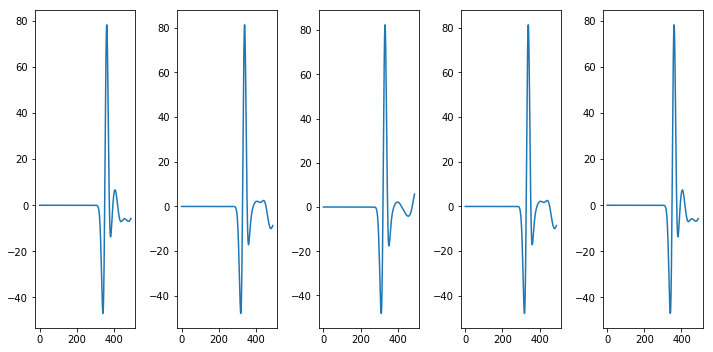

In [33]:
fig, axs = plt.subplots(1, recv_coords.shape[0], figsize=(10, 5))
fig.tight_layout()
for i, ax in enumerate(axs):
    axs[i].plot(rec2.data[:, i])

(491, 301, 301)
1446.019
-732.1023


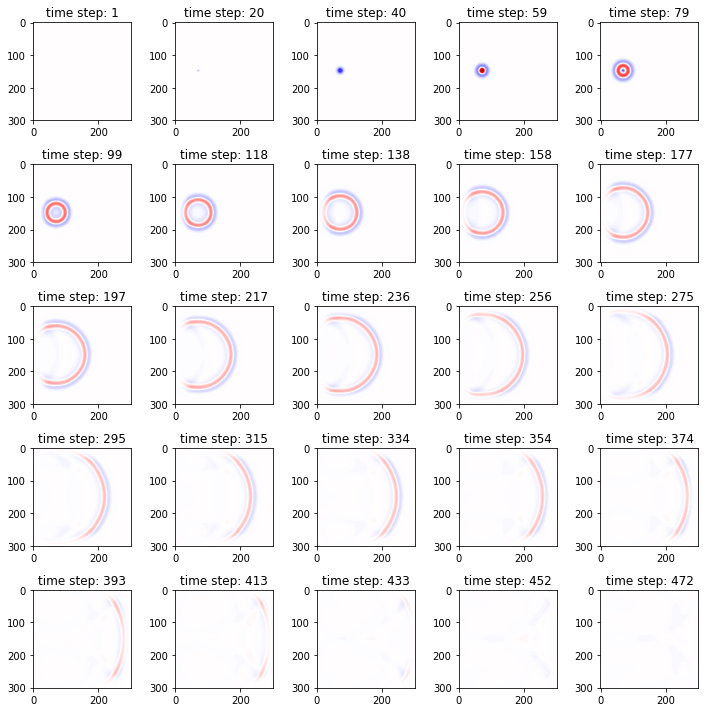

In [34]:
print(u.data.shape)
cols = 5
Nplots = 25
rows = Nplots // cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

print(np.max(u.data))
print(np.min(u.data))
vmin = np.min(u.data) / 2
vmax = np.max(u.data) / 2
vmin = -1 * (max(abs(vmin), abs(vmax)))
vmax = -1 * vmin
for j in range(rows):
    axs = axes[j, :]
    for i, ax in enumerate(axs):
        idx = int(j * cols + i)
        ax.imshow(u.data[idx * u.shape[0] // Nplots + 1].T, cmap='seismic', vmin=vmin, vmax=vmax)
        ax.set_title("time step: {}".format(idx * u.shape[0] // Nplots + 1))


fig.tight_layout()
# fig.colorbar(None)

In [2]:
dim = 2
shape = (201, 201)
# Spacing is in m, distance between grid points along an axis
spacing = (50, 50)
origin = (0, 0)
so, to = 2, 2
v_water = 1.500
v_rock = 2.000 # Could be upto 4.000 (salt closer to 5.000)
nbl = 50 # Number of boundary layers
xmax, ymax = (shape[0]-1 + 2 * nbl) * spacing[0], (shape[1]-1 + 2 * nbl) * spacing[1]
comp_xmax, comp_ymax = (shape[0]-1) * spacing[0], (shape[1]-1) * spacing[1]

n_src, n_recv = 1, 5
src_coords, recv_coords = np.zeros((n_src, dim)), np.zeros((n_recv, dim))
# Put source vertically in the middle of the domain, and 10% away from the left edge of the computational domain
src_coords[0] = [0.1 * comp_xmax, comp_ymax / 2]
# Put the receivers in a straight line along the right edge of the domain,
# about 10% away from the right edge of the computational domain
for k in range(n_recv):
    recv_coords[k] = [0.9 * comp_xmax, (0.1 + (1.0/n_recv) * k) * comp_ymax]
# print(src_coords, "\n", recv_coords)

# print(xmax, ymax)
v_initial = np.ones(shape) * v_water
# print(comp_xmax, comp_ymax)

v_initial = np.ones(shape) * v_water
# Instantiate model
b_initial = np.ones(shape)

# Set the right half of the domain to have a different buoyancy 
# b_initial[shape[0] // 2:, :] = 0.02
b_initial[shape[0] // 2:, :] = 0.5
model = Model(origin, spacing, shape, so, v_initial, nbl=nbl, bcs='damp', b=b_initial)

dt = model.critical_dt
t0 = 0
tn = 1e4
time_range = TimeAxis(start=t0, stop=tn, step=dt)
# Frequency kHz
f0 = 0.001

# print(model.grid.__dict__)


src = RickerSource(name='src', grid=model.grid, f0=f0,
                   npoint=src_coords.shape[0], time_range=time_range)
src.coordinates.data[:, :] = src_coords

rec = Receiver(name='rec', grid=model.grid, npoint=5, time_range=time_range)
rec.coordinates.data[:, :] = recv_coords

m = Function(name='m', grid=model.grid, space_order=so)
# rho = Function(name='rho', grid=model.grid, space_order=so)
u = TimeFunction(name='u', grid=model.grid, space_order=so, time_order=to, save=Buffer(time_range.num))
# print(model.damp)
# t, x, y = u.dimensions
# print(model.grid.dimensions)
t = model.grid.time_dim
x, y = model.grid.dimensions
# Define them explicitly so that they exist at the grid points themselves, and not in between
# Also have to deifne for u.dx, u.dy (?)
# b_dx = 0.5 * (model.b.dx(x0=x-x.spacing/2) + model.b.dx(x0=x+x.spacing/2))
# b_dy = 0.5 * (model.b.dx(x0=y-y.spacing/2) + model.b.dx(x0=y+y.spacing/2))
# u_dx = 0.5 * (u.dx(x0=x+x.spacing/2) + u.dx(x0=x-x.spacing/2))
# u_dy = 0.5 * (u.dy(x0=y+y.spacing/2) + u.dy(x0=y-y.spacing/2))
b_dx = 0.5 * (model.b.dx(x0=x-x.spacing/2) + model.b.dx(x0=x+x.spacing/2))
b_dy = 0.5 * (model.b.dy(x0=y-y.spacing/2) + model.b.dy(x0=y+y.spacing/2))
u_dx = 0.5 * (u.dx(x0=x-x.spacing/2) + u.dx(x0=x+x.spacing/2))
u_dy = 0.5 * (u.dy(x0=y-y.spacing/2) + u.dy(x0=y+y.spacing/2))
# print(b_dx)


pde = (model.m * u.dt2 - 1/model.b *(b_dx*u_dx
                                    +model.b*u.dx2
                                    +b_dy*u_dy
                                    +model.b*u.dy2) + model.damp * u.dt)

# THIS ONE SHOULD WORK:
# pde = model.m * u.dt2 -   1/model.b *(model.b.dx*u.dx+model.b*u.dx2+model.b.dy*u.dy+model.b*u.dy2) + model.damp * u.dt

# IDK about these
# pde = model.m * u.dt2 - 1/model.b * ((model.b * u.dx(x0=x+x.spacing/2)).dx(x0=x+x.spacing/2) + (model.b * u.dy(x0=y+y.spacing/2)).dy(x0=y+y.spacing/2)) + model.damp * u.dt
# pde = u.dt2 - 0.5 * (u.dx(x0=x-x.spacing/2) + u.dx(x0=x+x.spacing/2))

# pde = u.dt2  - u.dx
pde

Operator `initdamp` ran in 0.01 s
Operator `pad_vp` ran in 0.01 s
Operator `pad_b` ran in 0.01 s


-((0.5*Derivative(b(x, y), x) + 0.5*Derivative(b(x, y), x))*(0.5*Derivative(u(t, x, y), x) + 0.5*Derivative(u(t, x, y), x)) + (0.5*Derivative(b(x, y), y) + 0.5*Derivative(b(x, y), y))*(0.5*Derivative(u(t, x, y), y) + 0.5*Derivative(u(t, x, y), y)) + b(x, y)*Derivative(u(t, x, y), (x, 2)) + b(x, y)*Derivative(u(t, x, y), (y, 2)))/b(x, y) + damp(x, y)*Derivative(u(t, x, y), t) + Derivative(u(t, x, y), (t, 2))/vp(x, y)**2

In [3]:
print(u.dx.__dict__)

{'_dims': (x,), '_fd_order': 2, '_deriv_order': 1, '_side': None, '_transpose': direct[1], '_ppsubs': (), '_x0': <frozendict {}>}


In [4]:
stencil = Eq(u.forward, solve(pde, u.forward))

src_term = src.inject(field=u.forward, expr=src * (model.grid.stepping_dim.spacing)**2 / model.m)
rec_term = rec.interpolate(expr=u.forward)
stencil

Eq(u(t + dt, x, y), (((0.5*Derivative(b(x, y), x) + 0.5*Derivative(b(x, y), x))*(0.5*Derivative(u(t, x, y), x) + 0.5*Derivative(u(t, x, y), x)) + (0.5*Derivative(b(x, y), y) + 0.5*Derivative(b(x, y), y))*(0.5*Derivative(u(t, x, y), y) + 0.5*Derivative(u(t, x, y), y)) + b(x, y)*Derivative(u(t, x, y), (x, 2)) + b(x, y)*Derivative(u(t, x, y), (y, 2)))/b(x, y) - (-2.0*u(t, x, y)/dt**2 + u(t - dt, x, y)/dt**2)/vp(x, y)**2 + damp(x, y)*u(t, x, y)/dt)/(damp(x, y)/dt + 1/(dt**2*vp(x, y)**2)))

In [5]:
op = Operator(stencil + src_term + rec_term, subs=model.spacing_map)
op(time=time_range.num-1, dt=model.critical_dt)
print(op.ccode)

Operator `Kernel` ran in 0.13 s


#define _POSIX_C_SOURCE 200809L
#define START_TIMER(S) struct timeval start_ ## S , end_ ## S ; gettimeofday(&start_ ## S , NULL);
#define STOP_TIMER(S,T) gettimeofday(&end_ ## S, NULL); T->S += (double)(end_ ## S .tv_sec-start_ ## S.tv_sec)+(double)(end_ ## S .tv_usec-start_ ## S .tv_usec)/1000000;

#include "stdlib.h"
#include "math.h"
#include "sys/time.h"
#include "xmmintrin.h"
#include "pmmintrin.h"

struct dataobj
{
  void *restrict data;
  unsigned long * size;
  unsigned long * npsize;
  unsigned long * dsize;
  int * hsize;
  int * hofs;
  int * oofs;
} ;

struct profiler
{
  double section0;
  double section1;
  double section2;
} ;


int Kernel(struct dataobj *restrict b_vec, struct dataobj *restrict damp_vec, struct dataobj *restrict rec_vec, struct dataobj *restrict rec_coords_vec, struct dataobj *restrict src_vec, struct dataobj *restrict src_coords_vec, struct dataobj *restrict u_vec, struct dataobj *restrict vp_vec, const int x_M, const int x_m, const int y_M, const int

1446.019
-732.10236
(491, 301, 301)


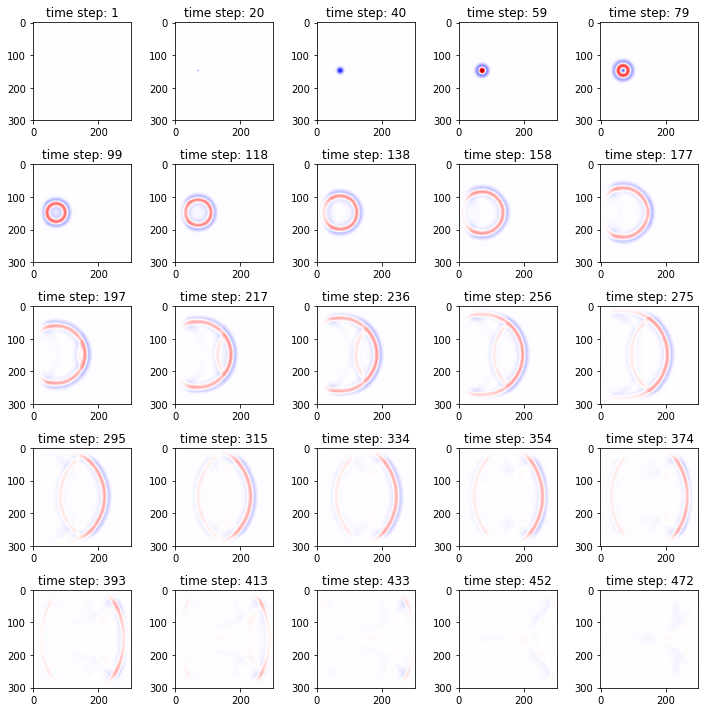

In [6]:
cols = 5
Nplots = 25
rows = Nplots // cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

print(np.max(u.data))
print(np.min(u.data))
vmin = np.min(u.data) / 2
vmax = np.max(u.data) / 2
vmin = -1 * (max(abs(vmin), abs(vmax)))
vmax = -1 * vmin
for j in range(rows):
    axs = axes[j, :]
    for i, ax in enumerate(axs):
        idx = int(j * cols + i)
        ax.imshow(u.data[idx * u.shape[0] // Nplots + 1].T, cmap='seismic', vmin=vmin, vmax=vmax)
        ax.set_title("time step: {}".format(idx * u.shape[0] // Nplots + 1))


fig.tight_layout()
print(u.shape)

In [24]:
print(op.ccode)

#define _POSIX_C_SOURCE 200809L
#define START_TIMER(S) struct timeval start_ ## S , end_ ## S ; gettimeofday(&start_ ## S , NULL);
#define STOP_TIMER(S,T) gettimeofday(&end_ ## S, NULL); T->S += (double)(end_ ## S .tv_sec-start_ ## S.tv_sec)+(double)(end_ ## S .tv_usec-start_ ## S .tv_usec)/1000000;

#include "stdlib.h"
#include "math.h"
#include "sys/time.h"
#include "xmmintrin.h"
#include "pmmintrin.h"

struct dataobj
{
  void *restrict data;
  unsigned long * size;
  unsigned long * npsize;
  unsigned long * dsize;
  int * hsize;
  int * hofs;
  int * oofs;
} ;

struct profiler
{
  double section0;
  double section1;
  double section2;
} ;


int Kernel(struct dataobj *restrict b_vec, struct dataobj *restrict damp_vec, struct dataobj *restrict rec_vec, struct dataobj *restrict rec_coords_vec, struct dataobj *restrict src_vec, struct dataobj *restrict src_coords_vec, struct dataobj *restrict u_vec, struct dataobj *restrict vp_vec, const int x_M, const int x_m, const int y_M, const int

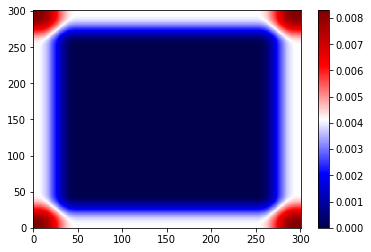

In [45]:
fig = plt.figure()
plt.pcolor(model.damp.data, cmap='seismic')
plt.colorbar()

In [51]:
print(np.isclose(model.damp.data, model.damp.data.T).all())
print(model.damp.data[50, 150], model.damp.data[49, 150])
print(model.damp.data[-50, 150], model.damp.data[-51, 150])

True
0.0 1.7398102e-06
1.7398102e-06 0.0


In [72]:
adj_pde = model.m * u.dt2.T - 1/model.b *(model.b.dx*u.dx+model.b*u.dx2+model.b.dy*u.dy+model.b*u.dy2) + model.damp * u.dt.T

adj_stencil = Eq(u.backward, solve(adj_pde, u.backward))
adj_stencil

s = model.grid.stepping_dim.spacing
src_adjterm = src.interpolate(expr=src * (model.grid.stepping_dim.spacing)**2 / model.m)
rec_adjterm = rec.inject(field=u.backward, expr=rec * s**2 / m)
adj_operator = Operator(adj_stencil + src_adjterm + rec_adjterm, subs=model.spacing_map)
# print(adj_operator)
adj_stencil

Eq(u(t - dt, x, y), ((b(x, y)*Derivative(u(t, x, y), (x, 2)) + b(x, y)*Derivative(u(t, x, y), (y, 2)) + Derivative(b(x, y), x)*Derivative(u(t, x, y), x) + Derivative(b(x, y), y)*Derivative(u(t, x, y), y))/b(x, y) - (-2.0*u(t, x, y)/dt**2 + u(t + dt, x, y)/dt**2)/vp(x, y)**2 + damp(x, y)*u(t, x, y)/dt)/(damp(x, y)/dt + 1/(dt**2*vp(x, y)**2)))

In [75]:
print(u.space_order)



2
#define _POSIX_C_SOURCE 200809L
#define START_TIMER(S) struct timeval start_ ## S , end_ ## S ; gettimeofday(&start_ ## S , NULL);
#define STOP_TIMER(S,T) gettimeofday(&end_ ## S, NULL); T->S += (double)(end_ ## S .tv_sec-start_ ## S.tv_sec)+(double)(end_ ## S .tv_usec-start_ ## S .tv_usec)/1000000;

#include "stdlib.h"
#include "math.h"
#include "sys/time.h"
#include "xmmintrin.h"
#include "pmmintrin.h"

struct dataobj
{
  void *restrict data;
  unsigned long * size;
  unsigned long * npsize;
  unsigned long * dsize;
  int * hsize;
  int * hofs;
  int * oofs;
} ;

struct profiler
{
  double section0;
  double section1;
  double section2;
} ;


int Kernel(struct dataobj *restrict b_vec, struct dataobj *restrict damp_vec, struct dataobj *restrict m_vec, struct dataobj *restrict rec_vec, struct dataobj *restrict rec_coords_vec, struct dataobj *restrict src_vec, struct dataobj *restrict src_coords_vec, struct dataobj *restrict u_vec, struct dataobj *restrict vp_vec, const int x_M, const

In [43]:
dim = 3
shape = (101, 101, 101)
# Spacing is in m, distance between grid points along an axis
spacing = (50, 50, 50)
origin = (0, 0, 0)

# Initial velocity profile (velocity in km/s)
v_water = 1.500
v_rock = 2.000 # Could be upto 4000 (salt closer to 5000)
# Number of boundary layers - TODO: revisit this
nbl = 20
xmax, ymax = (shape[0]-1 + 2 * nbl) * spacing[0], (shape[1]-1 + 2 * nbl) * spacing[1]
zmax = (shape[2]-1 + 2*nbl) * spacing[2]
v_initial = np.ones(shape)


model = Model(origin, spacing, shape, so, v_initial, nbl=nbl, bcs='damp', b=np.ones(v_initial.shape))
dt = model.critical_dt
print("Critical dt: {:.4f}ms".format(dt))

t0 = 0
tn = 2e4
time_range = TimeAxis(start=t0, stop=tn, step=dt)
# Frequency kHz
f0 = 0.001


src_coords3d = np.zeros((1, 3))
src_coords3d[0] = [500, 500, 500]
n_recv = 5
recv_coords3d = np.zeros((n_recv, 3))
for i in range(n_recv):
    recv_coords3d[i] = [9500 / 2, 9500 / 2, (1000 + i*2000) / 2]
print(recv_coords3d)
src = RickerSource(name='src', grid=model.grid, f0=f0,
                   npoint=src_coords3d.shape[0], time_range=time_range)
src.coordinates.data[:, :] = src_coords3d

rec = Receiver(name='rec', grid=model.grid, npoint=n_recv, time_range=time_range)
rec.coordinates.data[:, :] = recv_coords3d

m = Function(name='m', grid=model.grid, space_order=so)
# rho = Function(name='rho', grid=model.grid, space_order=so)
u = TimeFunction(name='u', grid=model.grid, space_order=so, time_order=to)
# Set rho's data - uniform to start with
# rho.data[:, :] = 1.0

# The (commented out) below formulations don't work because Devito doesn't like it when you do (model.b * u.dx).dx
# pde = model.m * u.dt2 - 1/ model.b * ((model.b * u.dx).dx + (model.b * u.dy).dy + (model.b * u.dz).dz) + model.damp * u.dt
# pde = model.m * u.dt2 - 1 / model.b * ((model.b * u.dx).dx + (model.b * u.dy).dy + (model.b * u.dz).dz)
# pde = model.m * u.dt2 - u.laplace + model.damp * u.dt
pde = (model.m * u.dt2 - 
       1/model.b *(model.b.dx*u.dx+model.b*u.dx2+model.b.dy*u.dy+model.b*u.dy2+model.b.dz*u.dz+model.b*u.dz2) 
       + model.damp * u.dt)
pde

Operator `initdamp` ran in 0.01 s
Operator `pad_vp` ran in 0.01 s
Operator `pad_b` ran in 0.01 s


Critical dt: 25.0000ms
[[4750. 4750.  500.]
 [4750. 4750. 1500.]
 [4750. 4750. 2500.]
 [4750. 4750. 3500.]
 [4750. 4750. 4500.]]


-(b(x, y, z)*Derivative(u(t, x, y, z), (x, 2)) + b(x, y, z)*Derivative(u(t, x, y, z), (y, 2)) + b(x, y, z)*Derivative(u(t, x, y, z), (z, 2)) + Derivative(b(x, y, z), x)*Derivative(u(t, x, y, z), x) + Derivative(b(x, y, z), y)*Derivative(u(t, x, y, z), y) + Derivative(b(x, y, z), z)*Derivative(u(t, x, y, z), z))/b(x, y, z) + damp(x, y, z)*Derivative(u(t, x, y, z), t) + Derivative(u(t, x, y, z), (t, 2))/vp(x, y, z)**2

In [44]:
stencil = Eq(u.forward, solve(pde, u.forward))
src_term = src.inject(field=u.forward, expr=src * (model.grid.stepping_dim.spacing)**2 / model.m)
rec_term = rec.interpolate(expr=u.forward)
stencil

Eq(u(t + dt, x, y, z), ((b(x, y, z)*Derivative(u(t, x, y, z), (x, 2)) + b(x, y, z)*Derivative(u(t, x, y, z), (y, 2)) + b(x, y, z)*Derivative(u(t, x, y, z), (z, 2)) + Derivative(b(x, y, z), x)*Derivative(u(t, x, y, z), x) + Derivative(b(x, y, z), y)*Derivative(u(t, x, y, z), y) + Derivative(b(x, y, z), z)*Derivative(u(t, x, y, z), z))/b(x, y, z) - (-2.0*u(t, x, y, z)/dt**2 + u(t - dt, x, y, z)/dt**2)/vp(x, y, z)**2 + damp(x, y, z)*u(t, x, y, z)/dt)/(damp(x, y, z)/dt + 1/(dt**2*vp(x, y, z)**2)))

In [45]:
op = Operator(stencil + src_term + rec_term, subs=model.spacing_map)
op(time=time_range.num-1, dt=model.critical_dt)

Operator `Kernel` ran in 7.19 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=7.17967000000001, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section1', rank=None),
                     PerfEntry(time=0.000881000000000013, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section2', rank=None),
                     PerfEntry(time=0.0008310000000000114, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

(801, 5)


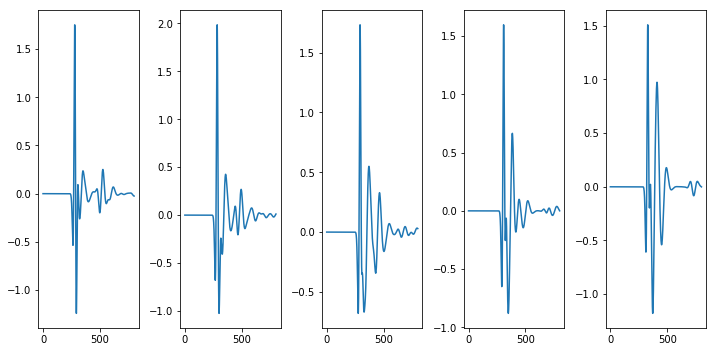

In [46]:
fig, axs = plt.subplots(1, n_recv, figsize=(10, 5))
fig.tight_layout()
for i, ax in enumerate(axs):
    axs[i].plot(rec.data[:, i])
print(rec.data.shape)

In [47]:
print(np.max(rec.data), np.min(rec.data))

1.9845712 -1.2420766
